In [1]:
import os
import importlib
from Faz1_MultiLabel_File_Dataset import utils

importlib.reload(utils)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers
import matplotlib.pyplot as plt
tf.test.is_built_with_cuda() #GPU aktif mi?

ORIGINAL_DATA_PATH = "datasets/CSV_Multi_Label_Classification"
AUGMENTED_DATA_PATH = "datasets/CSV_Multi_Label_Classification_Augmented"
print("TensorFlow version:", tf.__version__)
print("GPU Build Info:", tf.sysconfig.get_build_info())
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

# Bellek optimizasyonu (GPU kullanımı için)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)#TensorFlow’un başlangıçta minimum bellek tahsis etmesini ve yalnızca gerektiğinde bellek kullanmasını sağlar.

TensorFlow version: 2.10.1
GPU Build Info: OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Orijinal verileri yükle
original_train_df = utils.load_data('train', base_path=ORIGINAL_DATA_PATH)
original_valid_df = utils.load_data('valid', base_path=ORIGINAL_DATA_PATH)
original_test_df = utils.load_data('test', base_path=ORIGINAL_DATA_PATH)

# Tensorflow Dataset'leri oluştur
original_train_dataset = utils.create_dataset(original_train_df)
original_valid_dataset = utils.create_dataset(original_valid_df)
original_test_dataset = utils.create_dataset(original_test_df)

print("\nOrijinal Veri Seti Dağılımı:")
print(f"Train set: {len(original_train_df)} images")
print(f"Validation set: {len(original_valid_df)} images")
print(f"Test set: {len(original_test_df)} images")

print("\nOrijinal Eğitim Seti Etiket Dağılımı:")
print("Moderate Accident:", original_train_df['moderate'].sum())
print("Severe Accident:", original_train_df['severe'].sum())
print("No Accident:", original_train_df['no_accident'].sum())
print("Multi-label (Moderate & Severe):", ((original_train_df['moderate'] == 1) & (original_train_df['severe'] == 1)).sum())


Orijinal Veri Seti Dağılımı:
Train set: 10469 images
Validation set: 1004 images
Test set: 649 images

Orijinal Eğitim Seti Etiket Dağılımı:
Moderate Accident: 3402
Severe Accident: 6853
No Accident: 259
Multi-label (Moderate & Severe): 45


In [3]:
def create_model():
    model =models.Sequential([
        # İlk Convolutional blok
        layers.Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3), padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),#En önemli özellikler kalacak şekilde görüntüyü yarıya indirir.
        layers.Dropout(0.2),

        # İkinci Convolutional blok
        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.3),

        # Üçüncü Convolutional blok
        layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.4),

        # Dördüncü Convolutional Blok
        layers.Conv2D(256, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.4),

        #Sınıflandırma Katmanı
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(3, activation="softmax"),
    ])

    # Model derleme
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy',tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
    )
    return model
model = create_model()

In [4]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',#Doğrulama kaybını izle
        patience=10,#x epoch boyunca iyileşme olmazsa dur
        restore_best_weights=True,# En iyi ağırlıklara geri dön
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',# Doğrulama kaybı durursa
        factor=0.4,# Öğrenme oranını %x azalt
        patience=4,# x epoch boyunca iyileşme olmazsa lr düşür
        min_lr=1e-6, # En düşük learningrate oranı
        verbose = 1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_model_files/best_CNN_model.h5",
        monitor='val_loss',
        save_best_only=True,#en düşük val_loss olduğunda kaydet.
        mode='min',
    )
]

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                        

# Orjinal veri seti ile model eğitimi ve metrik sonuçları bölümü

In [7]:
history = model.fit(
    original_train_dataset,
    validation_data=original_valid_dataset,
    epochs=30,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/30
328/328 [==============================] - 98s 298ms/step - loss: 1.3113 - accuracy: 0.6002 - precision: 0.6160 - recall: 0.5526 - val_loss: 1.1384 - val_accuracy: 0.6155 - val_precision: 0.6195 - val_recall: 0.6115 - lr: 5.0000e-04
Epoch 2/30
328/328 [==============================] - 96s 293ms/step - loss: 1.0837 - accuracy: 0.6587 - precision: 0.6707 - recall: 0.6357 - val_loss: 1.1325 - val_accuracy: 0.6514 - val_precision: 0.6567 - val_recall: 0.6501 - lr: 5.0000e-04
Epoch 3/30
328/328 [==============================] - 96s 292ms/step - loss: 0.9322 - accuracy: 0.7123 - precision: 0.7213 - recall: 0.6976 - val_loss: 1.1143 - val_accuracy: 0.6713 - val_precision: 0.6737 - val_recall: 0.6690 - lr: 5.0000e-04
Epoch 4/30
328/328 [==============================] - 96s 292ms/step - loss: 0.8306 - accuracy: 0.7526 - precision: 0.7619 - recall: 0.7392 - val_loss: 1.3696 - val_accuracy: 0.6384 - val_precision: 0.6414 - val_recall: 0.6383 - lr: 5.0000e-04
Epoch 5/30
328/328 [====

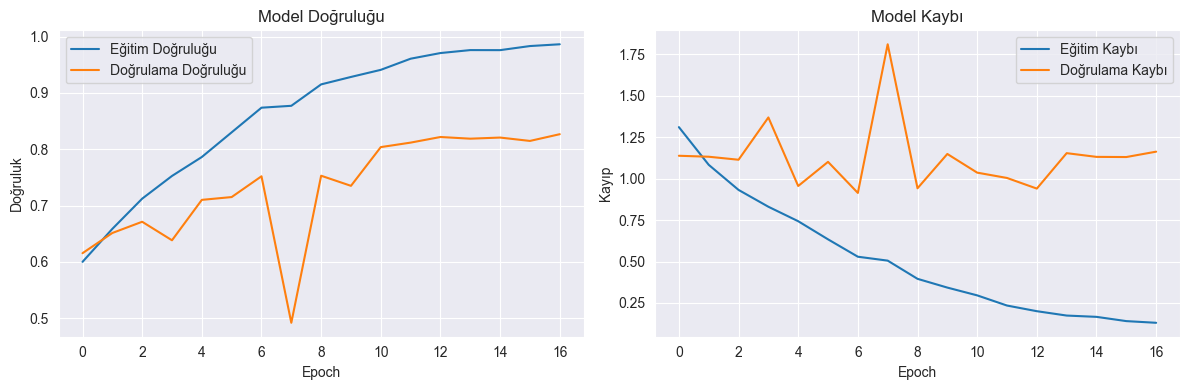

In [8]:
# Eğitim sonuçlarını görselleştir
plt.figure(figsize=(12, 4))#12X4 LÜK GRAFİK PENCERESİ OLUŞTUR.

#Accuracy Greafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

#Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.8089
F1 Score: 0.8081
ROC-AUC Score: 0.8625


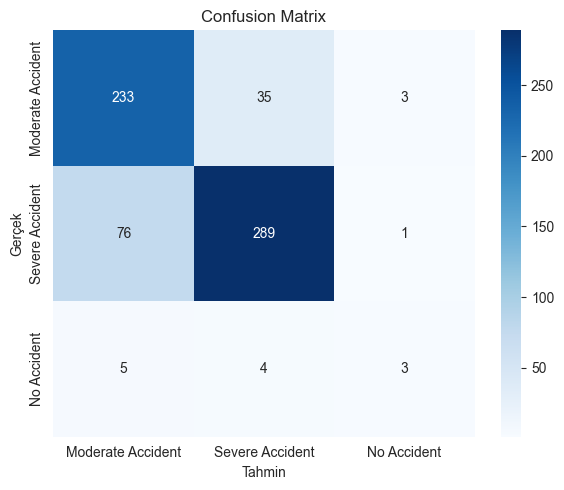


Sınıf Bazlı Performans:
                   precision    recall  f1-score   support

Moderate Accident       0.74      0.86      0.80       271
  Severe Accident       0.88      0.79      0.83       366
      No Accident       0.43      0.25      0.32        12

         accuracy                           0.81       649
        macro avg       0.68      0.63      0.65       649
     weighted avg       0.81      0.81      0.81       649



In [9]:
class_names = ['Moderate Accident', 'Severe Accident', 'No Accident']
utils.evaluate_model(model, original_test_dataset, class_names)

# Augmented veri seti ile model eğitimi ve metrik sonuçları

In [10]:
if not os.path.exists(os.path.join(AUGMENTED_DATA_PATH, 'train', '_classes.csv')):
    # Veri artırımı uygula ve yeni klasöre kaydet
    print("\nVeriler artırılıyor ve yeni dizine kaydediliyor...")
    utils.augment_and_save_data(original_train_df, 'train',
                                no_accident_aug_size=5, moderate_aug_size=0, severe_aug_size=0,
                                output_base_path=AUGMENTED_DATA_PATH)
else:
    print("Artırılmış veri seti zaten mevcut, mevcut veriler kullanılıyor.")

# Artırılmış train veri setini yükle
train_df = utils.load_data('train', base_path=AUGMENTED_DATA_PATH)
valid_df = utils.load_data('valid', base_path=ORIGINAL_DATA_PATH)
test_df = utils.load_data('test', base_path=ORIGINAL_DATA_PATH)

# Tensorflow Dataset'leri oluştur
augmented_train_dataset = utils.create_dataset(train_df)
augmented_valid_dataset = utils.create_dataset(valid_df)
augmented_test_dataset = utils.create_dataset(test_df)

print(f"\nGüncel Train set: {len(train_df)} images")
print(f"Güncel Validation set: {len(valid_df)} images")
print(f"Güncel Test set: {len(test_df)} images")

# Güncel etiket dağılımını kontrol et
print("\nGüncel Eğitim seti etiket dağılımı:")
print("Moderate Accident:", train_df['moderate'].sum())
print("Severe Accident:", train_df['severe'].sum())
print("No Accident:", train_df['no_accident'].sum())
print("Multi-label (Moderate & Severe):", ((train_df['moderate'] == 1) & (train_df['severe'] == 1)).sum())

Artırılmış veri seti zaten mevcut, mevcut veriler kullanılıyor.

Güncel Train set: 11764 images
Güncel Validation set: 1004 images
Güncel Test set: 649 images

Güncel Eğitim seti etiket dağılımı:
Moderate Accident: 3402
Severe Accident: 6853
No Accident: 1554
Multi-label (Moderate & Severe): 45


In [11]:
def create_model():
    model = models.Sequential([
        # Blok 1
        layers.Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3), padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.1),

        # Blok 2
        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2),

        # Blok 3
        layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.2),

        # Blok 4
        layers.Conv2D(256, (3,3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.3),

        # Sınıflandırma
        layers.GlobalAveragePooling2D(),

        layers.Dense(512, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(3, activation="softmax"),
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0004),
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

model = create_model()

In [12]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',#Doğrulama kaybını izle
        patience=10,#x epoch boyunca iyileşme olmazsa dur
        restore_best_weights=True,# En iyi ağırlıklara geri dön
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',# Doğrulama kaybı durursa
        factor=0.4,# Öğrenme oranını %x azalt
        patience=4,# x epoch boyunca iyileşme olmazsa lr düşür
        min_lr=1e-6, # En düşük learningrate oranı
        verbose = 1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_model_files/best_CNN_augmented_model.h5",
        monitor='val_loss',
        save_best_only=True,#en düşük val_loss olduğunda kaydet.
        mode='min',
    )
]

In [13]:
history = model.fit(
    augmented_train_dataset,
    validation_data=original_valid_dataset,
    epochs=30,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/30
368/368 [==============================] - 98s 261ms/step - loss: 1.1731 - accuracy: 0.5213 - val_loss: 1.1064 - val_accuracy: 0.3715 - lr: 4.0000e-04
Epoch 2/30
368/368 [==============================] - 93s 252ms/step - loss: 0.9029 - accuracy: 0.6174 - val_loss: 0.9009 - val_accuracy: 0.6554 - lr: 4.0000e-04
Epoch 3/30
368/368 [==============================] - 93s 252ms/step - loss: 0.7878 - accuracy: 0.6665 - val_loss: 0.8828 - val_accuracy: 0.6474 - lr: 4.0000e-04
Epoch 4/30
368/368 [==============================] - 92s 251ms/step - loss: 0.6821 - accuracy: 0.7095 - val_loss: 0.7063 - val_accuracy: 0.7112 - lr: 4.0000e-04
Epoch 5/30
368/368 [==============================] - 93s 251ms/step - loss: 0.5748 - accuracy: 0.7642 - val_loss: 0.7049 - val_accuracy: 0.6873 - lr: 4.0000e-04
Epoch 6/30
368/368 [==============================] - 93s 251ms/step - loss: 0.4645 - accuracy: 0.8153 - val_loss: 0.8566 - val_accuracy: 0.7341 - lr: 4.0000e-04
Epoch 7/30
368/368 [========

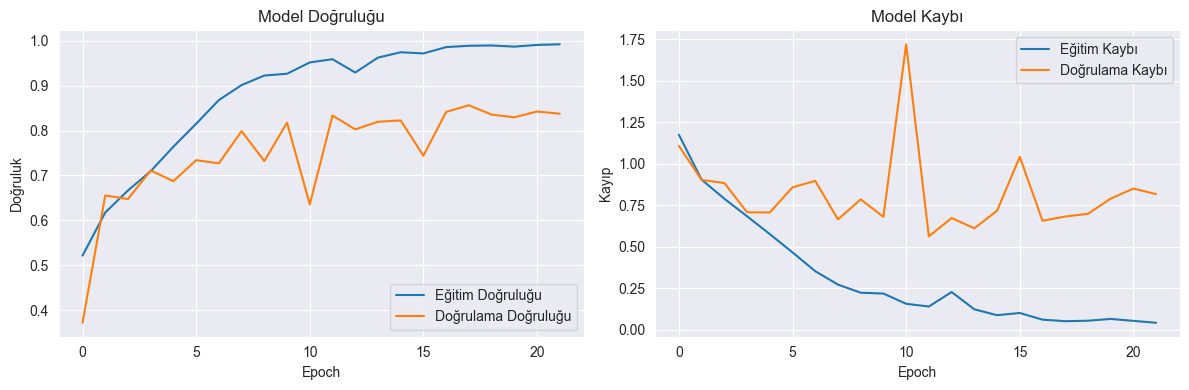

In [14]:
# Eğitim sonuçlarını görselleştir
plt.figure(figsize=(12, 4))#12X4 LÜK GRAFİK PENCERESİ OLUŞTUR.

#Accuracy Greafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

#Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.8983
F1 Score: 0.8978
ROC-AUC Score: 0.9471


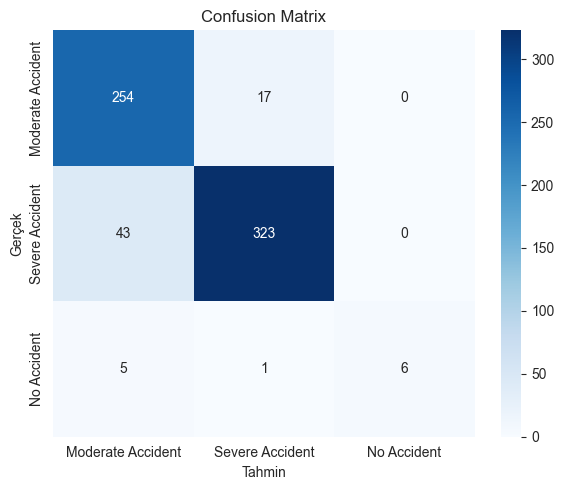


Sınıf Bazlı Performans:
                   precision    recall  f1-score   support

Moderate Accident       0.84      0.94      0.89       271
  Severe Accident       0.95      0.88      0.91       366
      No Accident       1.00      0.50      0.67        12

         accuracy                           0.90       649
        macro avg       0.93      0.77      0.82       649
     weighted avg       0.90      0.90      0.90       649



In [15]:
class_names = ['Moderate Accident', 'Severe Accident', 'No Accident']
utils.evaluate_model(model, augmented_test_dataset, class_names)

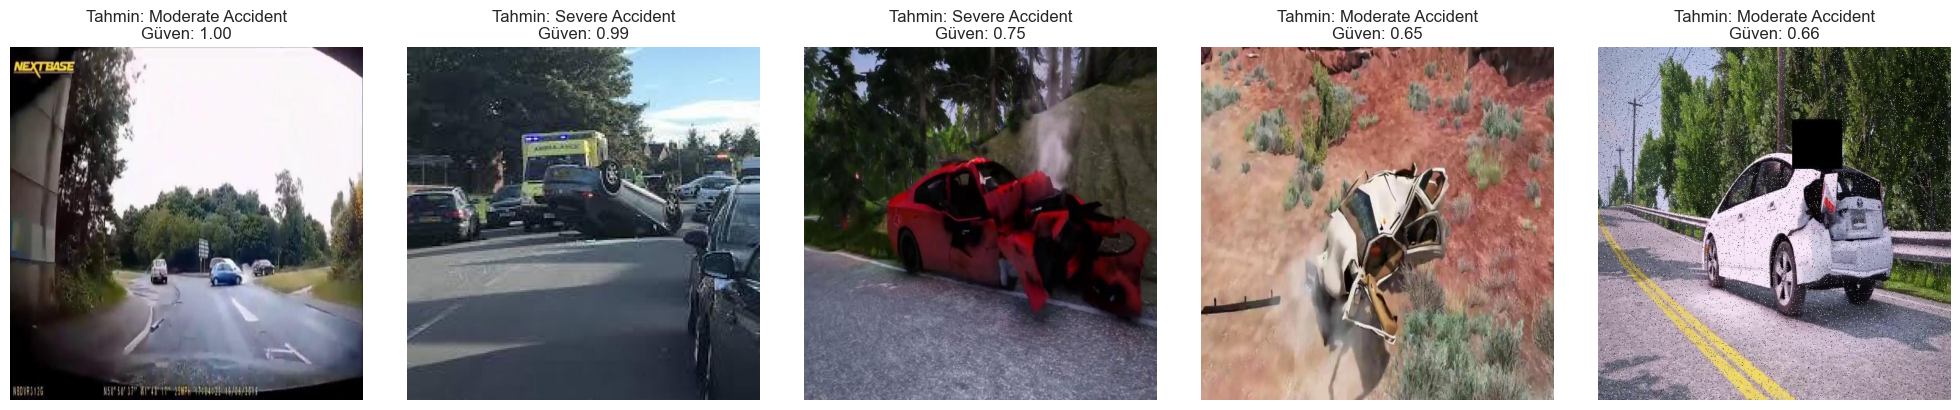

In [16]:
test_image_paths = test_df['filename'].tolist()  # Test seti görüntü yolları
# Tahminlerin görselleştirilmesi
utils.visualize_predictions(
    model=model,
    image_paths=test_image_paths,
    class_names=class_names,
    num_images=5
)